<a href="https://colab.research.google.com/github/pragmatic-ninja/human_pose/blob/master/Human_Pose_Module_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVHN CNN network

## Download data

In [0]:
!mkdir -p /content/svhn_data
!wget -nc -q -O /content/svhn_data/train_32x32.mat http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget -nc -q -O /content/svhn_data/test_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

## Custom Dataloader

In [0]:
import scipy.io
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


class MatLoader(Dataset):
  def __init__(self, path_name, set_name, transform):
    self.mat = scipy.io.loadmat(path_name % set_name)
    self.transform = transform
  
  def __getitem__(self, index):
    classification = self.mat['y'][index]
    image = self.mat['X'][:,:,:,index]
    x = image # np.transpose(image, (2, 0, 1)) #torch.from_numpy(
    y = classification if classification != 10 else 0
    return (transform(x), int(y))

  def __len__(self):
    return len(self.mat['y'])


In [0]:
path_name = './svhn_data/%s_32x32.mat'
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = MatLoader(path_name=path_name, set_name='train',transform=transform)
test_set = MatLoader(path_name=path_name, set_name='test',transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=200, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=200, shuffle=False, num_workers=0)

tensor([1, 9, 2, 3, 2, 5, 9, 3, 3, 1, 3, 3, 2, 8, 7, 4, 4, 1, 2, 8, 1, 6, 2, 3,
        6, 3, 4, 2, 5, 8, 1, 6, 2, 3, 7, 9, 5, 3, 2, 2, 2, 6, 2, 2, 5, 1, 5, 4,
        7, 8, 9, 6, 0, 1, 2, 4, 5, 6, 5, 2, 1, 3, 2, 1, 4, 6, 3, 8, 4, 3, 1, 4,
        4, 2, 6, 4, 4, 1, 1, 1, 7, 3, 1, 2, 0, 4, 2, 2, 5, 1, 2, 9, 2, 0, 4, 1,
        0, 3, 2, 7, 2, 4, 4, 6, 8, 1, 7, 1, 0, 3, 9, 1, 3, 5, 9, 3, 1, 1, 1, 1,
        3, 7, 5, 6, 2, 1, 5, 1, 1, 2, 4, 7, 5, 3, 2, 4, 3, 2, 9, 5, 8, 9, 5, 1,
        0, 5, 4, 2, 4, 4, 3, 1, 2, 3, 8, 6, 1, 5, 3, 3, 3, 1, 8, 9, 8, 7, 3, 9,
        1, 3, 8, 1, 9, 2, 2, 2, 2, 7, 4, 4, 5, 6, 0, 3, 1, 7, 3, 5, 1, 7, 5, 1,
        8, 1, 6, 4, 1, 9, 3, 3])


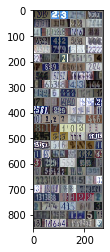

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(labels)


In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class Net(nn.Module):
    def __init__(self, layerDepth):
        super(Net, self).__init__()
        self.layerDepth = layerDepth
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 64, kernel_size=2, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=2, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=2, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            #nn.Dropout(),
            nn.Linear(64 * 2 * 2, self.layerDepth),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(self.layerDepth, self.layerDepth),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(self.layerDepth, self.layerDepth),
            nn.ReLU(inplace=True),
            nn.Linear(self.layerDepth, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [44]:
import torch.optim as optim

net = Net(4096)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

if torch.cuda.is_available():
    net.cuda()

for epoch in range(60):  # loop over the dataset multiple times

    running_loss = 0.0

    # changing the learning rate after 20
    if epoch == 20:
      for param_group in optimizer.param_groups:
        param_group['lr'] = 0.0001

    if epoch == 40:
      for param_group in optimizer.param_groups:
        param_group['lr'] = 0.00001

    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('[epoch %d] loss: %.3f' % (epoch + 1, running_loss / 500))

print('Finished Training')


[epoch 1] loss: 0.816
[epoch 2] loss: 0.344
[epoch 3] loss: 0.278
[epoch 4] loss: 0.247
[epoch 5] loss: 0.226
[epoch 6] loss: 0.210
[epoch 7] loss: 0.197
[epoch 8] loss: 0.184
[epoch 9] loss: 0.178
[epoch 10] loss: 0.167
[epoch 11] loss: 0.163
[epoch 12] loss: 0.158
[epoch 13] loss: 0.151
[epoch 14] loss: 0.140
[epoch 15] loss: 0.134
[epoch 16] loss: 0.132
[epoch 17] loss: 0.127
[epoch 18] loss: 0.122
[epoch 19] loss: 0.116
[epoch 20] loss: 0.115
[epoch 21] loss: 0.085
[epoch 22] loss: 0.069
[epoch 23] loss: 0.061
[epoch 24] loss: 0.056
[epoch 25] loss: 0.052
[epoch 26] loss: 0.049
[epoch 27] loss: 0.045
[epoch 28] loss: 0.043
[epoch 29] loss: 0.039
[epoch 30] loss: 0.037
[epoch 31] loss: 0.035
[epoch 32] loss: 0.034
[epoch 33] loss: 0.032
[epoch 34] loss: 0.029
[epoch 35] loss: 0.028
[epoch 36] loss: 0.026
[epoch 37] loss: 0.026
[epoch 38] loss: 0.024
[epoch 39] loss: 0.023
[epoch 40] loss: 0.022
[epoch 41] loss: 0.020
[epoch 42] loss: 0.019
[epoch 43] loss: 0.018
[epoch 44] loss: 0.0

GroundTruth:  tensor([5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, 4, 1, 6, 3, 4, 2, 0, 1, 3,
        2, 5, 4, 1, 4, 2, 8, 3, 8, 6, 0, 1, 5, 1, 1, 2, 9, 1, 6, 9, 2, 6, 1, 2,
        0, 6, 9, 1, 5, 1, 9, 8, 1, 5, 1, 5, 2, 9, 2, 4, 1, 0, 6, 9, 3, 2, 3, 5,
        1, 1, 4, 6, 2, 8, 3, 1, 4, 1, 7, 1, 2, 1, 7, 1, 0, 1, 4, 4, 6, 4, 4, 2,
        8, 1, 7, 7, 4, 8, 2, 3, 2, 2, 3, 1, 8, 6, 3, 7, 6, 3, 0, 7, 2, 7, 4, 2,
        8, 8, 1, 7, 1, 9, 3, 4, 2, 9, 6, 2, 6, 0, 8, 2, 0, 1, 0, 3, 2, 2, 4, 6,
        7, 2, 1, 3, 5, 3, 1, 5, 9, 1, 8, 1, 2, 6, 4, 6, 4, 9, 3, 6, 1, 0, 1, 2,
        5, 2, 7, 5, 2, 2, 1, 4, 2, 9, 6, 7, 1, 0, 2, 1, 4, 8, 3, 2, 1, 6, 2, 6,
        1, 1, 2, 3, 6, 1, 1, 3], device='cuda:0')
Predicted:  tensor([5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, 4, 1, 6, 3, 4, 2, 0, 1, 9,
        2, 5, 4, 1, 4, 2, 9, 3, 8, 6, 0, 1, 5, 1, 1, 2, 9, 1, 6, 9, 2, 8, 1, 2,
        0, 6, 9, 1, 5, 1, 9, 5, 4, 5, 1, 9, 2, 9, 2, 4, 1, 0, 6, 9, 3, 2, 3, 5,
        1, 1, 4, 6, 2, 8, 3, 1, 4, 1, 7, 1, 

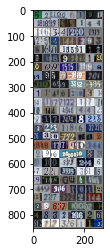

In [16]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

if torch.cuda.is_available():
  images = images.cuda()
  labels = labels.cuda()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',labels)

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', predicted)

In [45]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 92 %


In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 92 %
Accuracy of     1 : 95 %
Accuracy of     2 : 95 %
Accuracy of     3 : 89 %
Accuracy of     4 : 93 %
Accuracy of     5 : 92 %
Accuracy of     6 : 91 %
Accuracy of     7 : 92 %
Accuracy of     8 : 87 %
Accuracy of     9 : 90 %
